In [117]:
import numpy as np
import matplotlib.pyplot as plt
import time
import shtns

In [118]:
class Spharmt(object):
    """
    wrapper class for commonly used spectral transform operations in
    atmospheric models.  Provides an interface to shtns compatible
    with pyspharm (pyspharm.googlecode.com).
    """
    def __init__(self, nlons, nlats, ntrunc, rsphere, gridtype="gaussian"):
        """initialize
        nlons:  number of longitudes
        nlats:  number of latitudes"""
        self._shtns = shtns.sht(ntrunc, ntrunc, 1,
                                shtns.sht_orthonormal+shtns.SHT_NO_CS_PHASE)
        if gridtype == "gaussian":
            # self._shtns.set_grid(nlats, nlons,
            #         shtns.sht_gauss_fly | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_quick_init | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
        elif gridtype == "regular":
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_reg_dct | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
        self.lats = np.arcsin(self._shtns.cos_theta)
        self.lons = (2.*np.pi/nlons)*np.arange(nlons)
        self.nlons = nlons
        self.nlats = nlats
        self.ntrunc = ntrunc
        self.nlm = self._shtns.nlm
        self.degree = self._shtns.l
        self.lap = -self.degree*(self.degree+1.0).astype(complex)
        self.invlap = np.zeros(self.lap.shape, self.lap.dtype)
        self.invlap[1:] = 1./self.lap[1:]
        self.rsphere = rsphere
        self.lap = self.lap/rsphere**2
        self.invlap = self.invlap*rsphere**2
    def grdtospec(self, data):
        """compute spectral coefficients from gridded data"""
        return self._shtns.analys(data)
    def spectogrd(self, dataspec):
        """compute gridded data from spectral coefficients"""
        return self._shtns.synth(dataspec)
    def getuv(self, vrtspec, divspec):
        """compute wind vector from spectral coeffs of vorticity and divergence"""
        return self._shtns.synth((self.invlap/self.rsphere)*vrtspec, (self.invlap/self.rsphere)*divspec)
    def getvrtdivspec(self, u, v):
        """compute spectral coeffs of vorticity and divergence from wind vector"""
        vrtspec, divspec = self._shtns.analys(u, v)
        return self.lap*self.rsphere*vrtspec, self.lap*rsphere*divspec
    def getgrad(self, divspec):
        """compute gradient vector from spectral coeffs"""
        vrtspec = np.zeros(divspec.shape, dtype=complex)
        u, v = self._shtns.synth(vrtspec, divspec)
        return u/rsphere, v/rsphere

In [270]:
nlons = 512
nlats = 256
ntrunc = int(nlons/3)

dt = 120
Nday = 200
itmax = Nday*int(86400/dt)

rsphere = 6.37122e6
omega = 7.292e-5
grav = 9.80616
hbar = 3000*grav

efold = 3.*3600
ndiss = 8

x = Spharmt(nlons, nlats, ntrunc, rsphere, gridtype="gaussian")
lons, lats = np.meshgrid(x.lons, x.lats)
f = 2.*omega*np.sin(lats)   # coriolis

#####
vorticity_all = np.zeros((Nday+1, nlats, nlons), float)
#structure = 1e-11*np.exp((-((lons-np.pi)**2+(lats-40*np.pi/180)**2)/0.001))
structure = 1e-11*np.sin(5*lons)*np.sin(50*lons)*np.exp((-((lats-40*np.pi/180)**2)/0.001))
# 
ug = np.zeros((nlats, nlons), float)
vg = np.zeros((nlats, nlons), float)

# initial vorticity, divergence in spectral space
vrtspec, divspec = x.getvrtdivspec(ug, vg)
vrtg = x.spectogrd(vrtspec)
divg = x.spectogrd(divspec)

hyperdiff_fact = np.exp((-dt/efold)*(x.lap/x.lap[-1])**(ndiss/2))

phig = np.zeros((nlats, nlons), float)
phispec = x.grdtospec(phig)

ddivdtspec = np.zeros(vrtspec.shape+(3,), complex)
dvrtdtspec = np.zeros(vrtspec.shape+(3,), complex)
dphidtspec = np.zeros(vrtspec.shape+(3,), complex)

nnew = 0
nnow = 1
nold = 2

# time loop.
time1 = time.time()
t = 0
count = 0
for ncycle in range(itmax+1):
    t = ncycle*dt
    
    if t%86400 == 0:
        print("Time: ", t//86400)
        vorticity_all[count] = vrtg
        count += 1
    
    vrtg = x.spectogrd(vrtspec)
    ug, vg = x.getuv(vrtspec, divspec)
    phig = x.spectogrd(phispec)
    
    tmpg1 = ug*(vrtg+f)
    tmpg2 = vg*(vrtg+f)
    _, dvrtdtspec[:, nnew] = x.getvrtdivspec(tmpg1, tmpg2)
    dvrtdtspec[:, nnew] *= -1

    forcing = structure*np.cos(7.27e-7*t)
    dvrtdtspec[:, nnew] += x.grdtospec(forcing)
    
    dphidtspec[:, nnew] = 0.0
    ddivdtspec[:, nnew] = 0.0

    if ncycle == 0:
        dvrtdtspec[:, nnow] = dvrtdtspec[:, nnew]
        dvrtdtspec[:, nold] = dvrtdtspec[:, nnew]
        ddivdtspec[:, nnow] = ddivdtspec[:, nnew]
        ddivdtspec[:, nold] = ddivdtspec[:, nnew]
        dphidtspec[:, nnow] = dphidtspec[:, nnew]
        dphidtspec[:, nold] = dphidtspec[:, nnew]
    elif ncycle == 1:
        dvrtdtspec[:, nold] = dvrtdtspec[:, nnew]
        ddivdtspec[:, nold] = ddivdtspec[:, nnew]
        dphidtspec[:, nold] = dphidtspec[:, nnew]

    vrtspec += dt*((23./12.)*dvrtdtspec[:, nnew] - (16./12.)*dvrtdtspec[:, nnow] + (5./12.)*dvrtdtspec[:, nold])
    divspec += dt*((23./12.)*ddivdtspec[:, nnew] - (16./12.)*ddivdtspec[:, nnow] + (5./12.)*ddivdtspec[:, nold])
    phispec += dt*((23./12.)*dphidtspec[:, nnew] - (16./12.)*dphidtspec[:, nnow] + (5./12.)*dphidtspec[:, nold])

    vrtspec *= hyperdiff_fact
    #divspec *= hyperdiff_fact

    nsav1 = nnew
    nsav2 = nnow
    nnew = nold
    nnow = nsav1
    nold = nsav2

time2 = time.time()
print("CPU time = ", time2-time1)
# make a contour plot of potential vorticity in the Northern Hem.

Time:  0
Time:  1
Time:  2
Time:  3
Time:  4
Time:  5
Time:  6
Time:  7
Time:  8
Time:  9
Time:  10
Time:  11
Time:  12
Time:  13
Time:  14
Time:  15
Time:  16
Time:  17
Time:  18
Time:  19
Time:  20
Time:  21
Time:  22
Time:  23
Time:  24
Time:  25
Time:  26
Time:  27
Time:  28
Time:  29
Time:  30
Time:  31
Time:  32
Time:  33
Time:  34
Time:  35
Time:  36
Time:  37
Time:  38
Time:  39
Time:  40
Time:  41
Time:  42
Time:  43
Time:  44
Time:  45
Time:  46
Time:  47
Time:  48
Time:  49
Time:  50
Time:  51
Time:  52
Time:  53
Time:  54
Time:  55
Time:  56
Time:  57
Time:  58
Time:  59
Time:  60
Time:  61
Time:  62
Time:  63
Time:  64
Time:  65
Time:  66
Time:  67
Time:  68
Time:  69
Time:  70
Time:  71
Time:  72
Time:  73
Time:  74
Time:  75
Time:  76
Time:  77
Time:  78
Time:  79
Time:  80
Time:  81
Time:  82
Time:  83
Time:  84
Time:  85
Time:  86
Time:  87
Time:  88
Time:  89
Time:  90
Time:  91
Time:  92
Time:  93
Time:  94
Time:  95
Time:  96
Time:  97
Time:  98
Time:  99
Time:  100

max/min PV -1.1090821070822585 1.1256983304283579


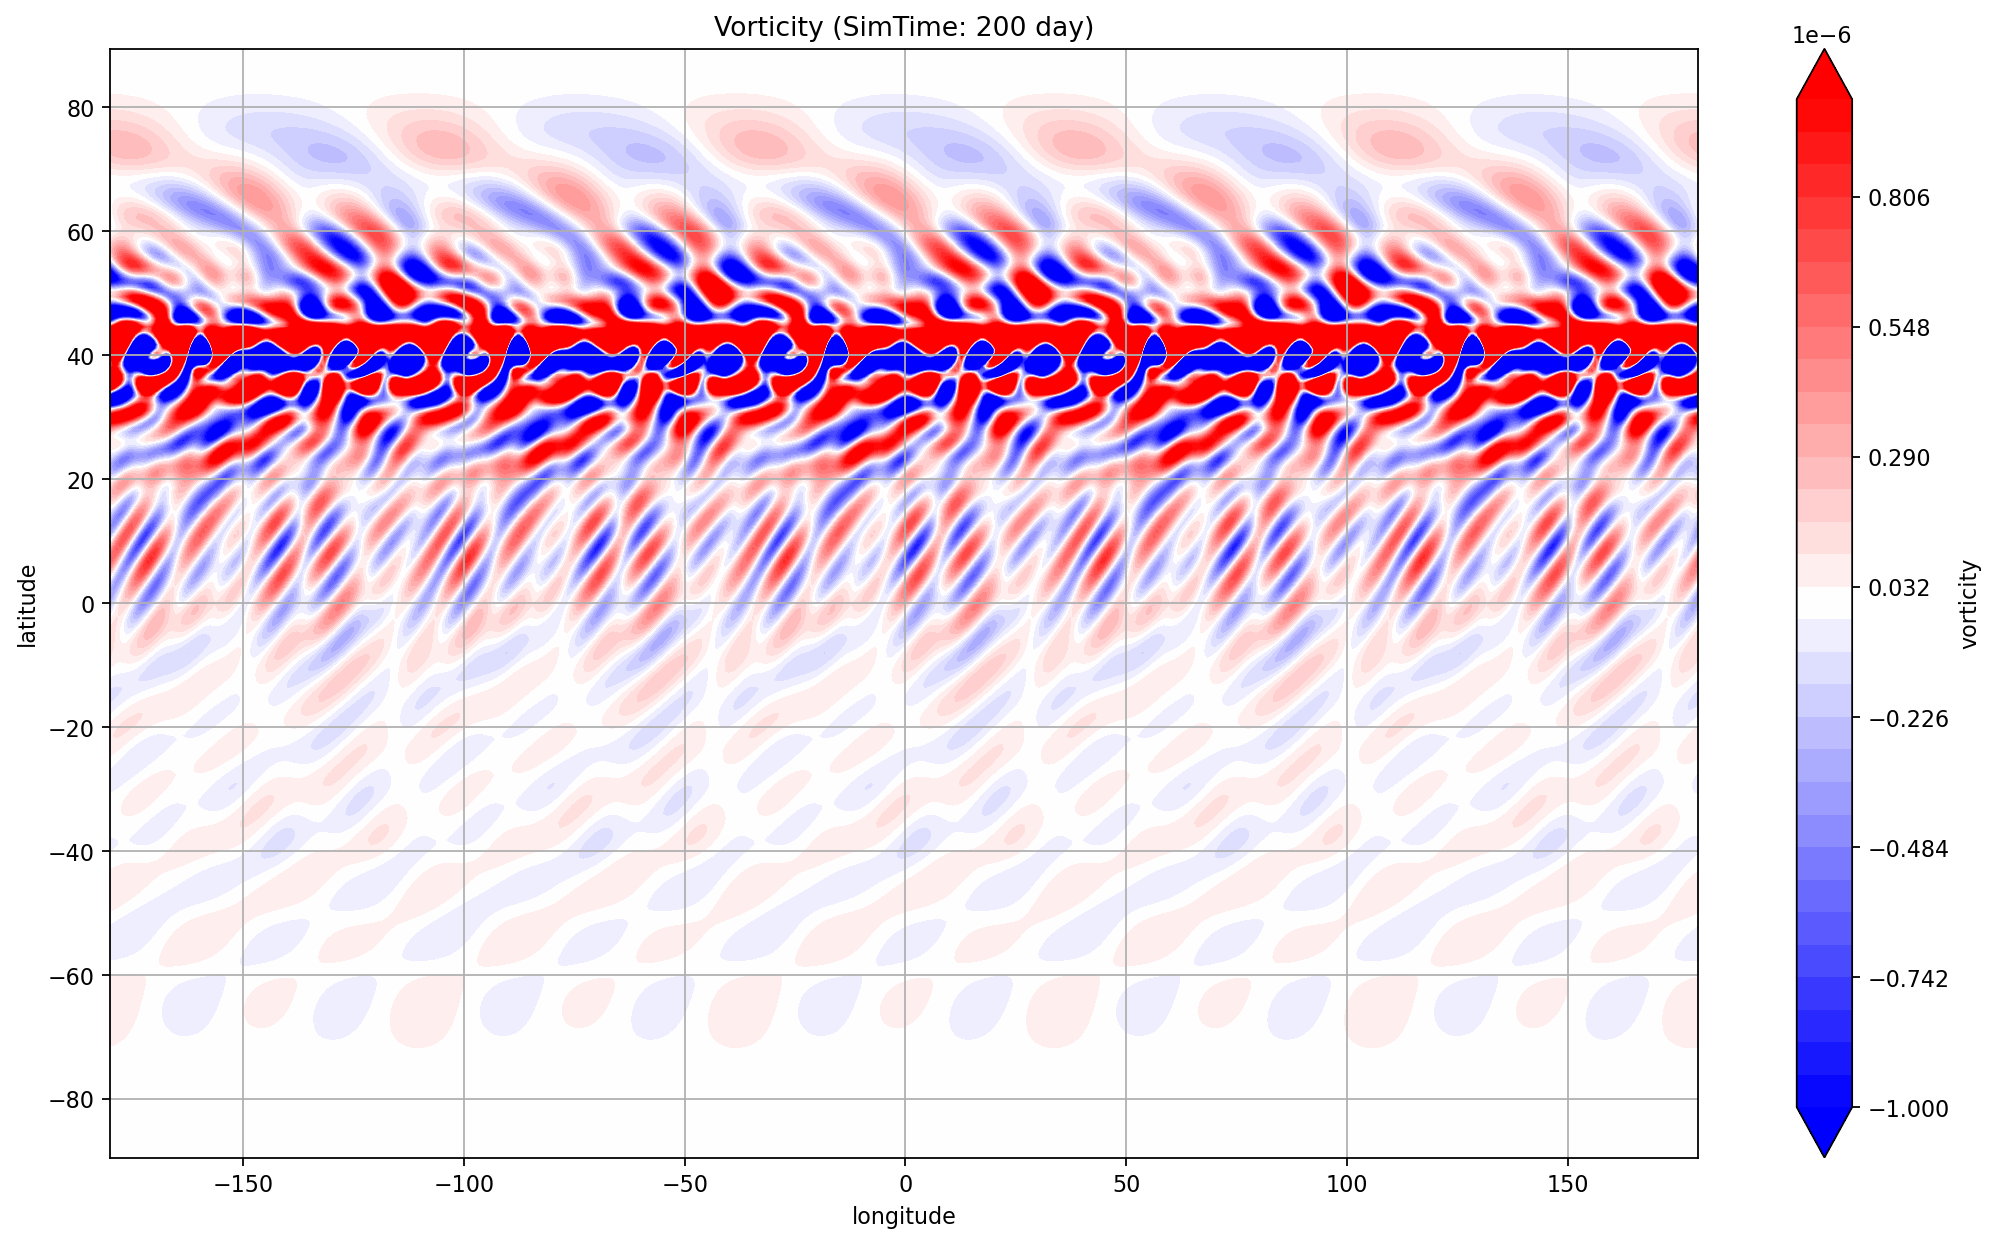

In [271]:
fig = plt.figure(figsize=(16, 9), dpi = 160)
# dimensionless PV

print("max/min PV", vg.min(), vg.max())
lons1d = (180./np.pi)*x.lons-180.
lats1d = (180./np.pi)*x.lats
levs = np.linspace(-1e-6, 1e-6,32)

cs = plt.contourf(lons1d, lats1d, vorticity_all[-1], levs, extend="both", cmap="bwr")
cb = plt.colorbar(cs, orientation="vertical")
cb.set_label("vorticity")

plt.grid()
plt.xlabel("longitude")
plt.ylabel("latitude")
#plt.xticks(np.arange(-180, 181, 60))
#plt.yticks(np.arange(-5, 81, 20))
plt.axis("equal")
plt.axis("tight")
#plt.ylim(0, lats1d[0])
plt.title("Vorticity (SimTime: %3.0f day)" % (t/86400))
#plt.savefig("output_swe.pdf")
plt.show()

In [292]:
k = np.fft.fftshift(np.fft.fftfreq(512,2*np.pi*rsphere/512/(2*np.pi)))
l = np.fft.fftshift(np.fft.fftfreq(256,1.25*np.pi*rsphere/256/(2*np.pi)))
#print(k)

In [244]:
2*omega*np.cos(40*np.pi/180)/rsphere

1.7535090859281545e-11

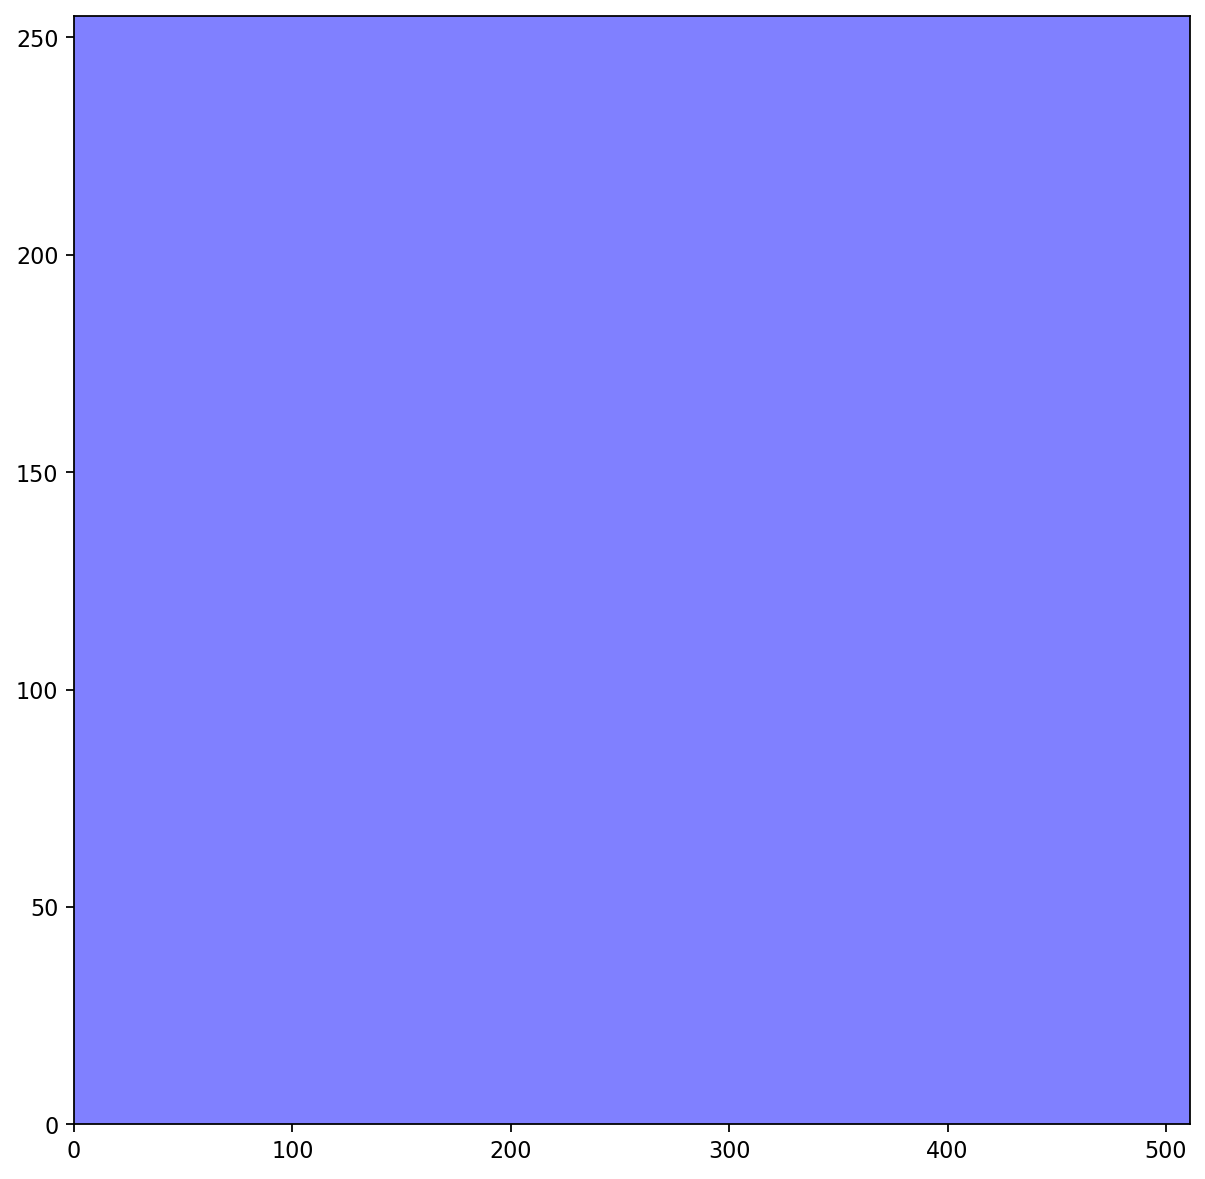

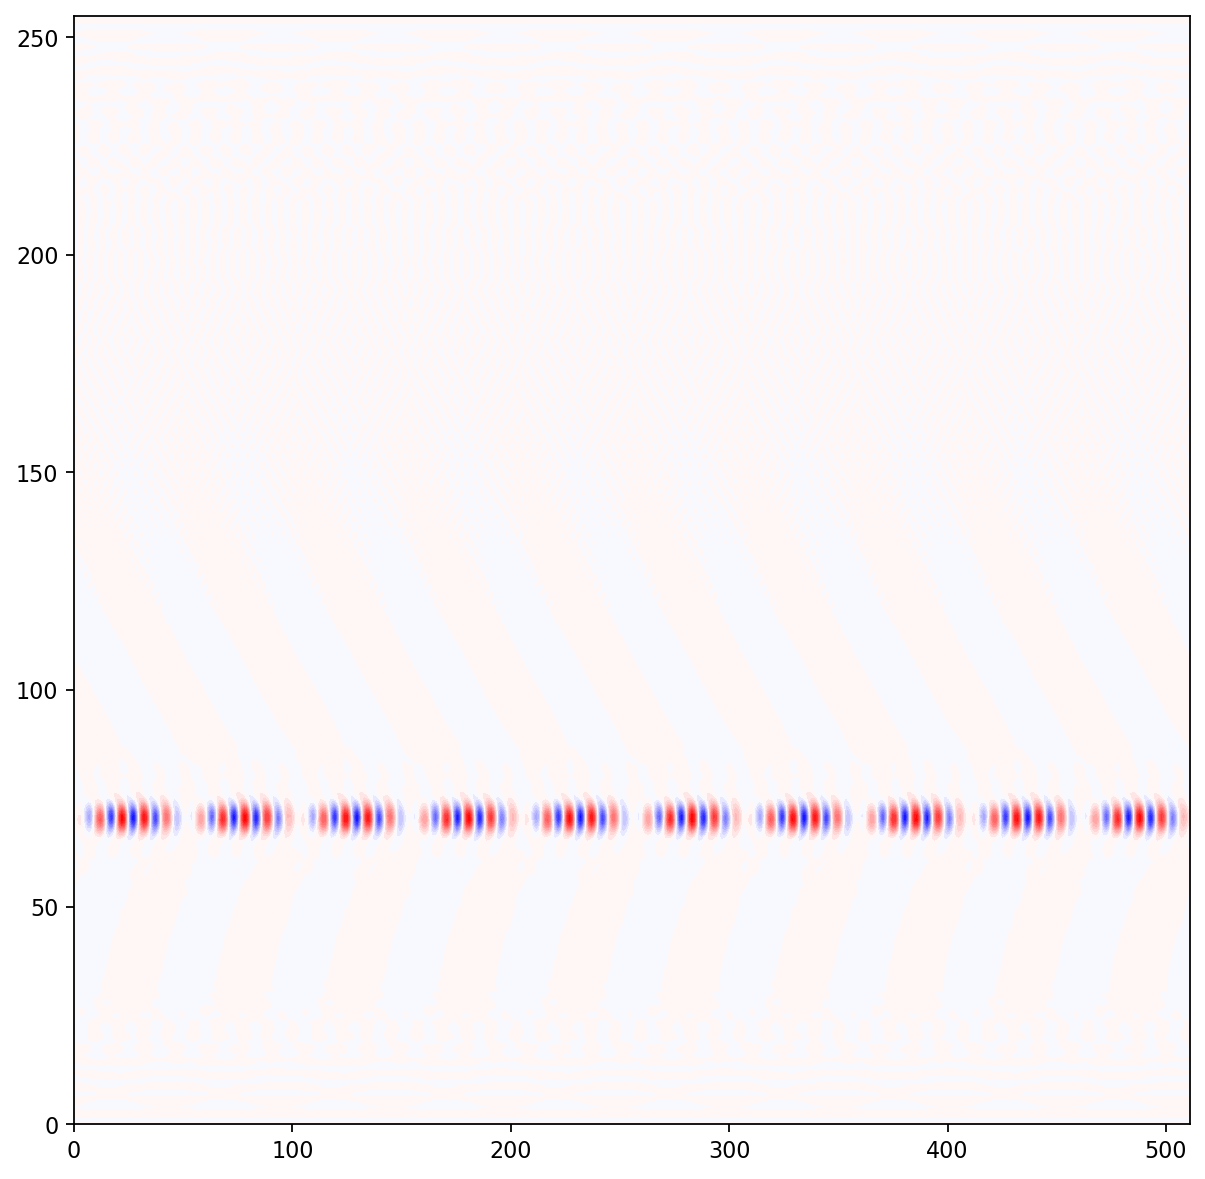

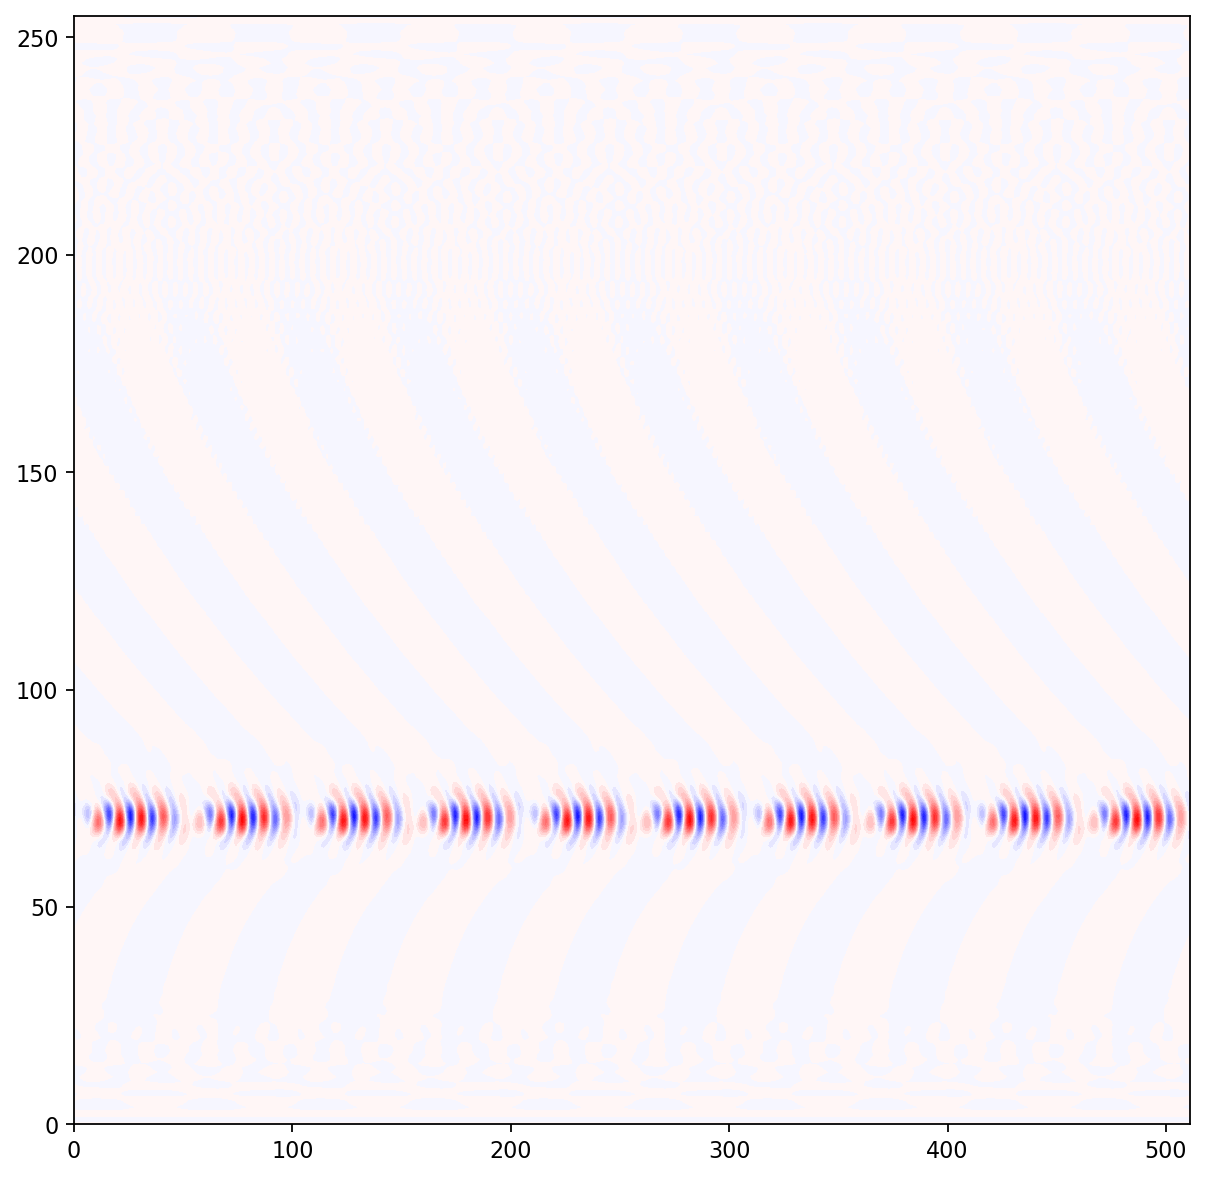

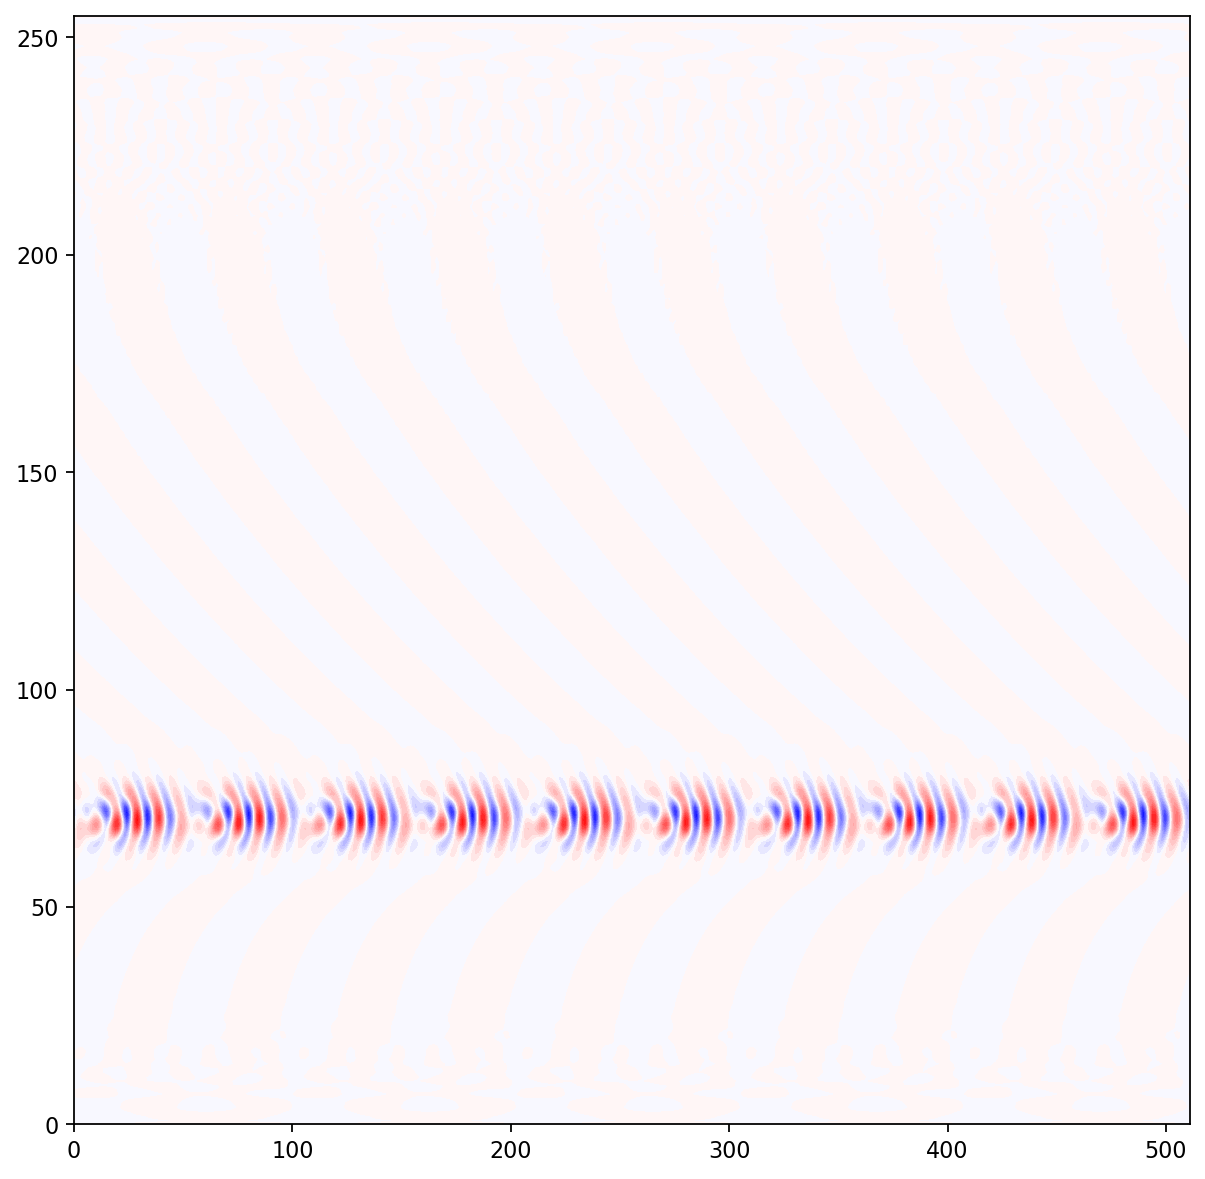

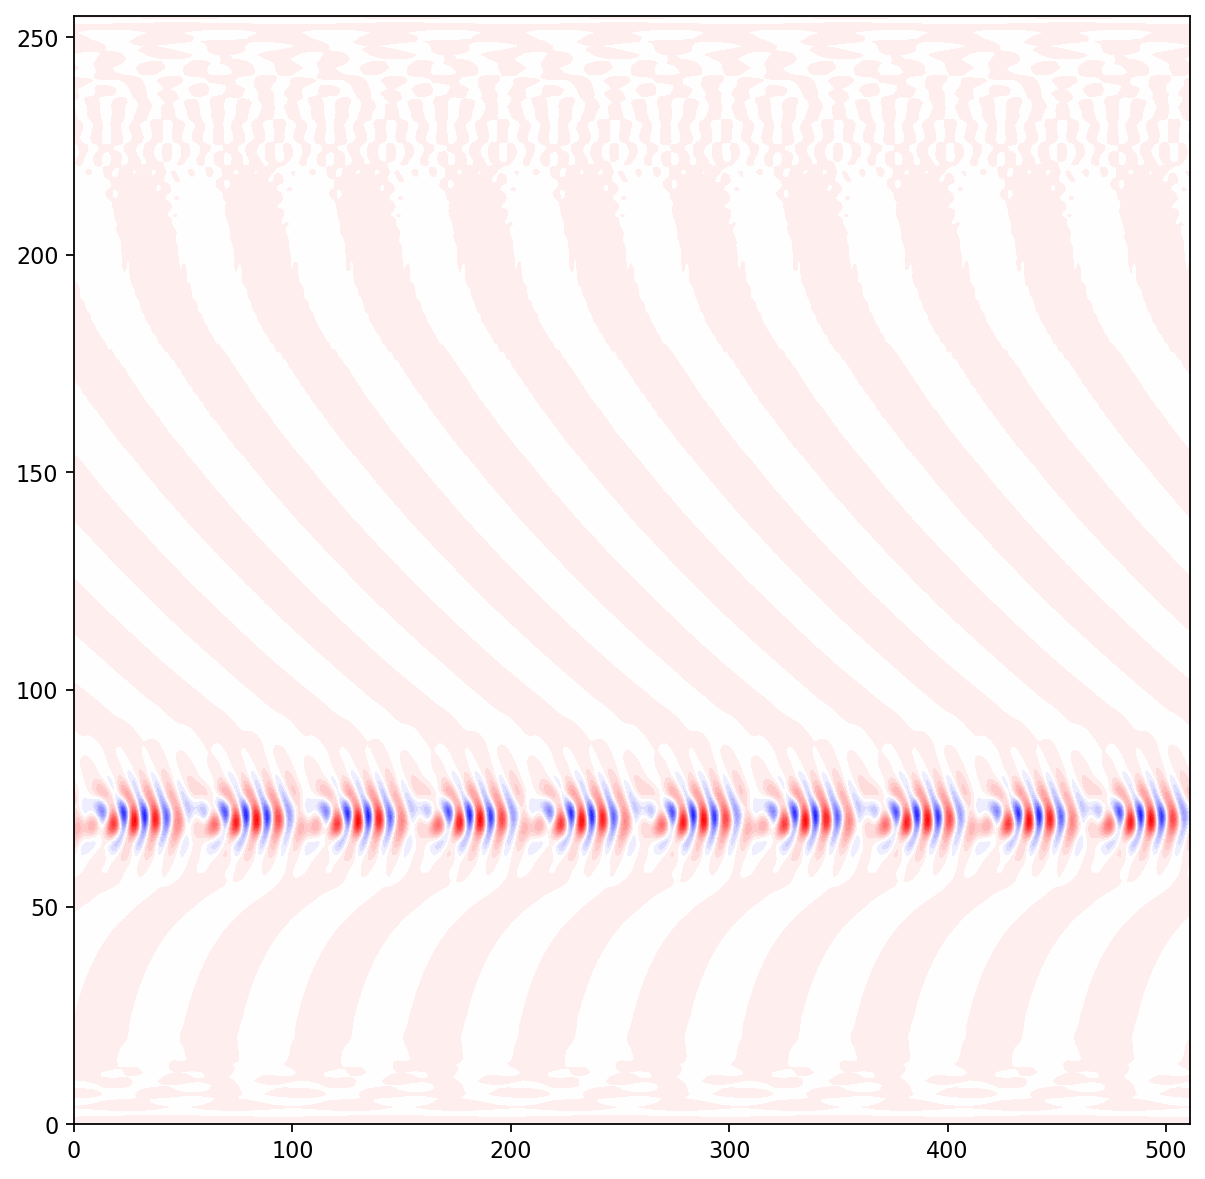

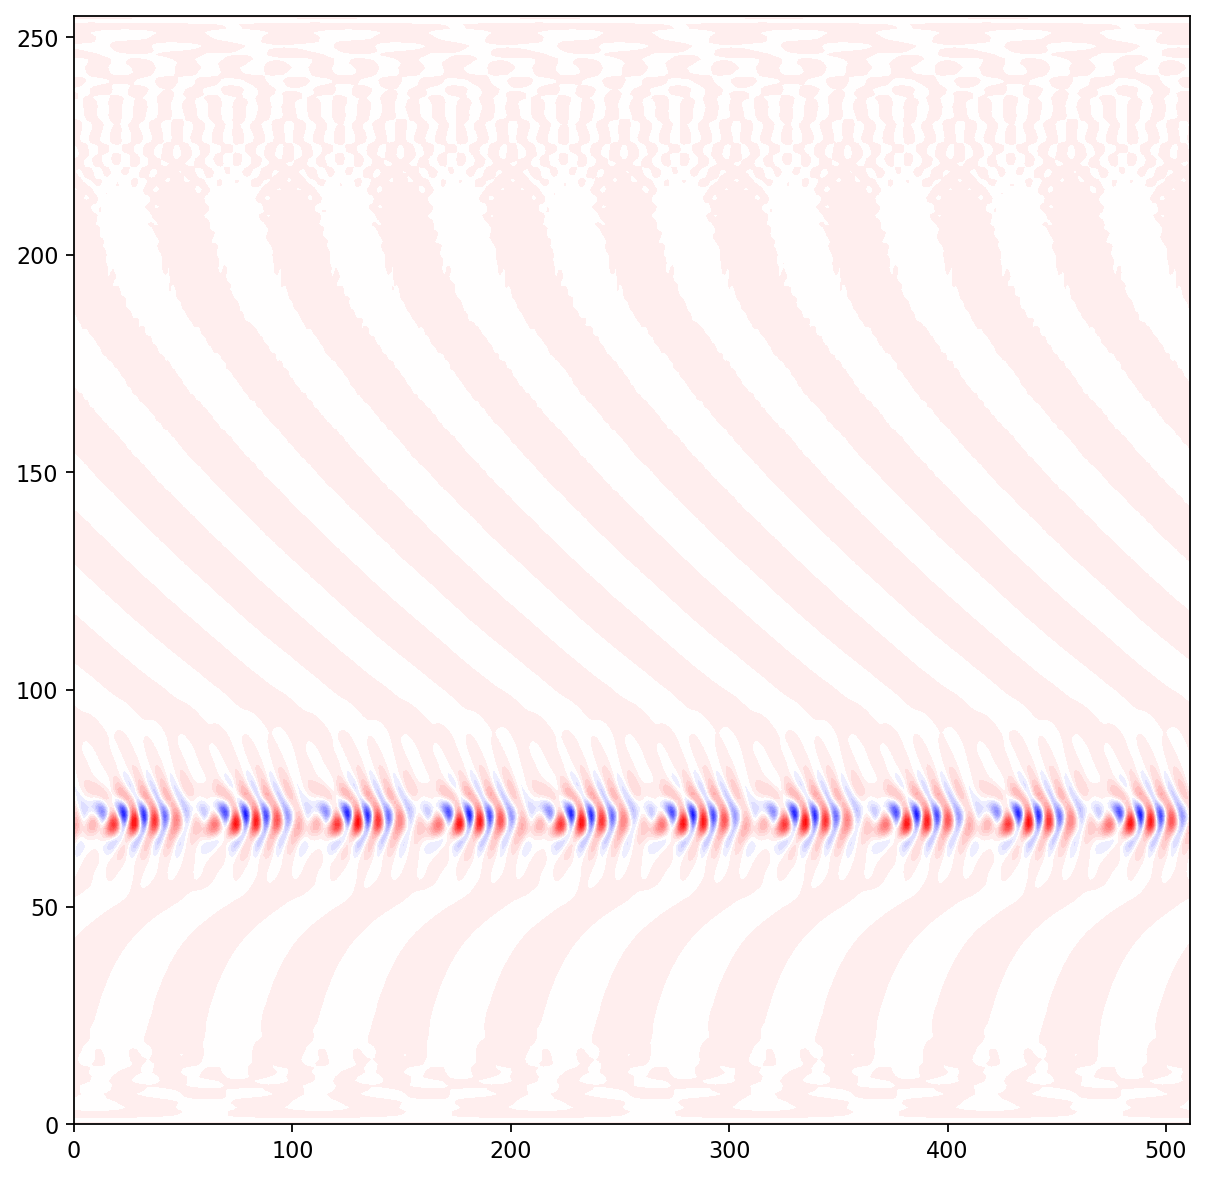

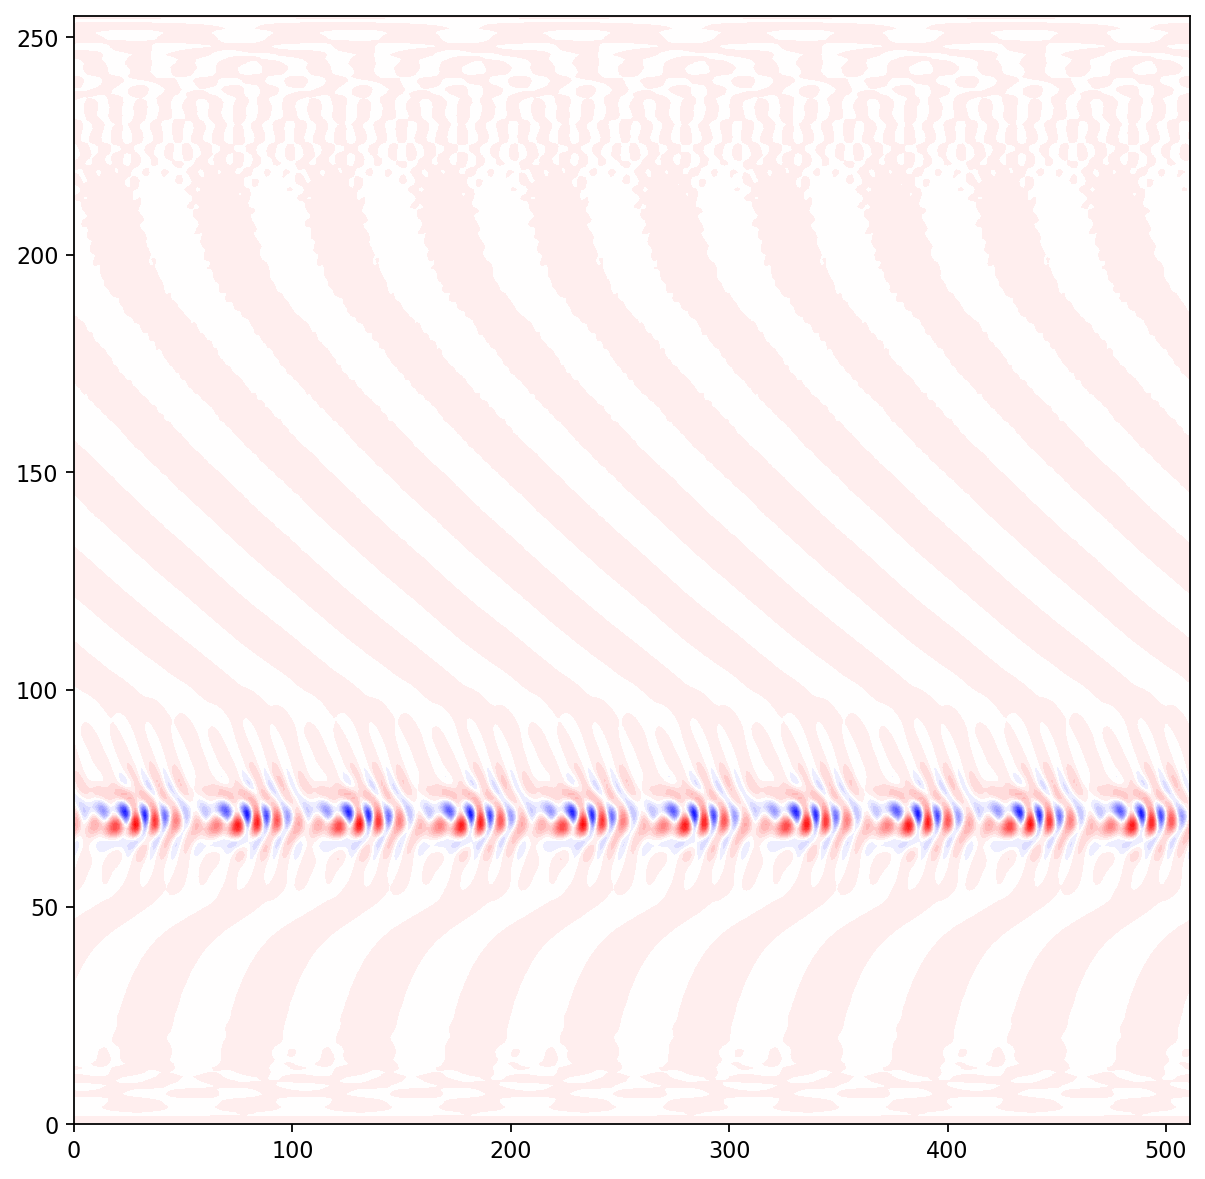

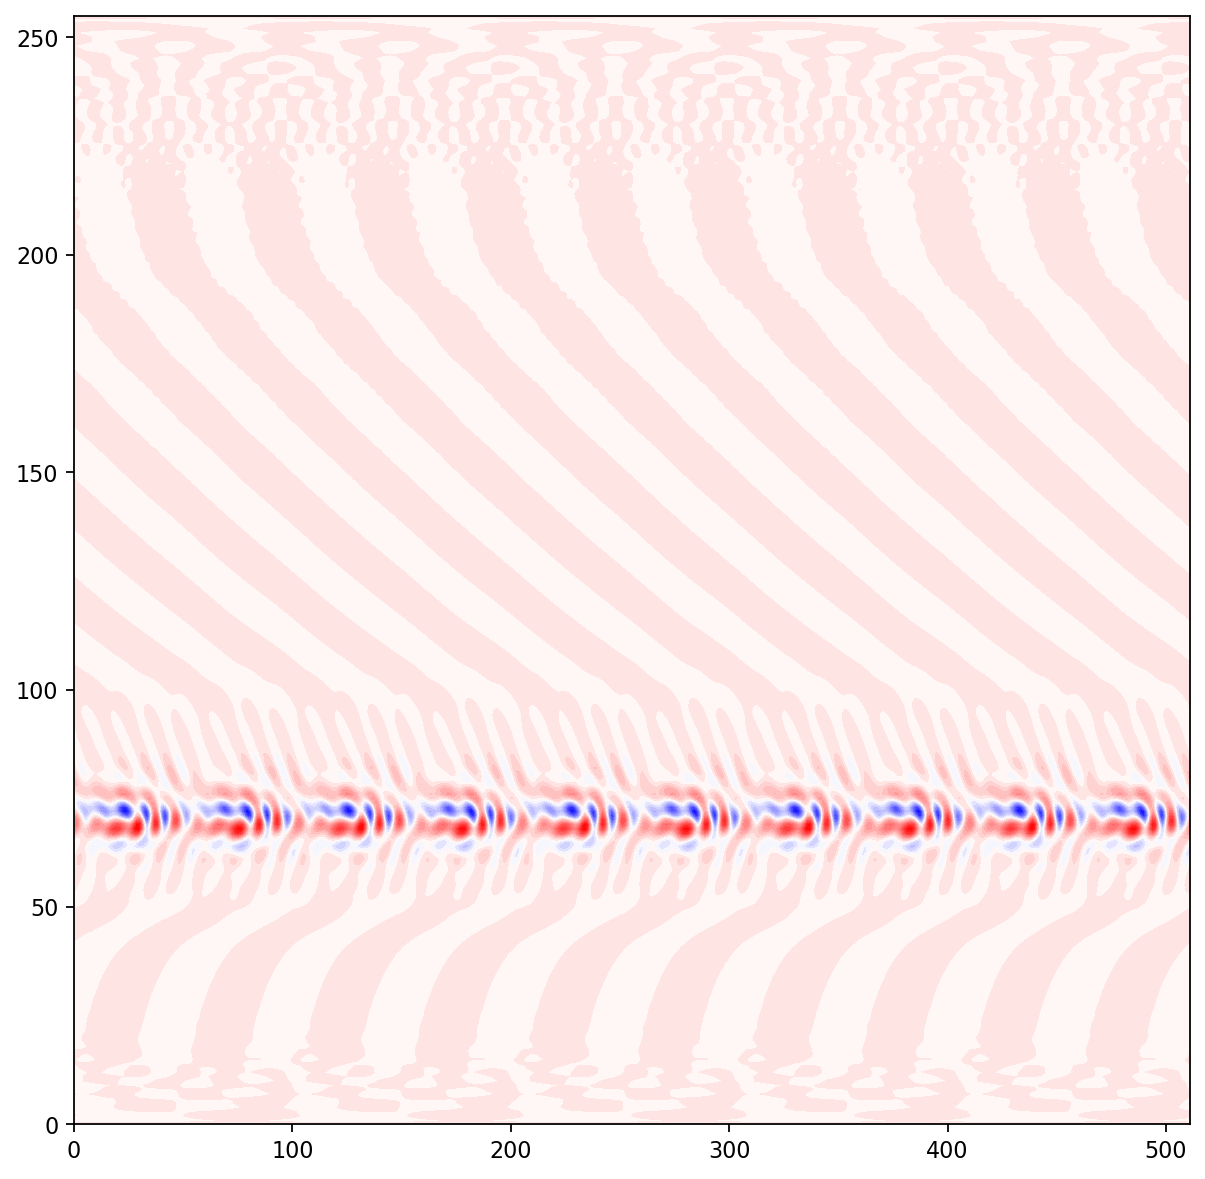

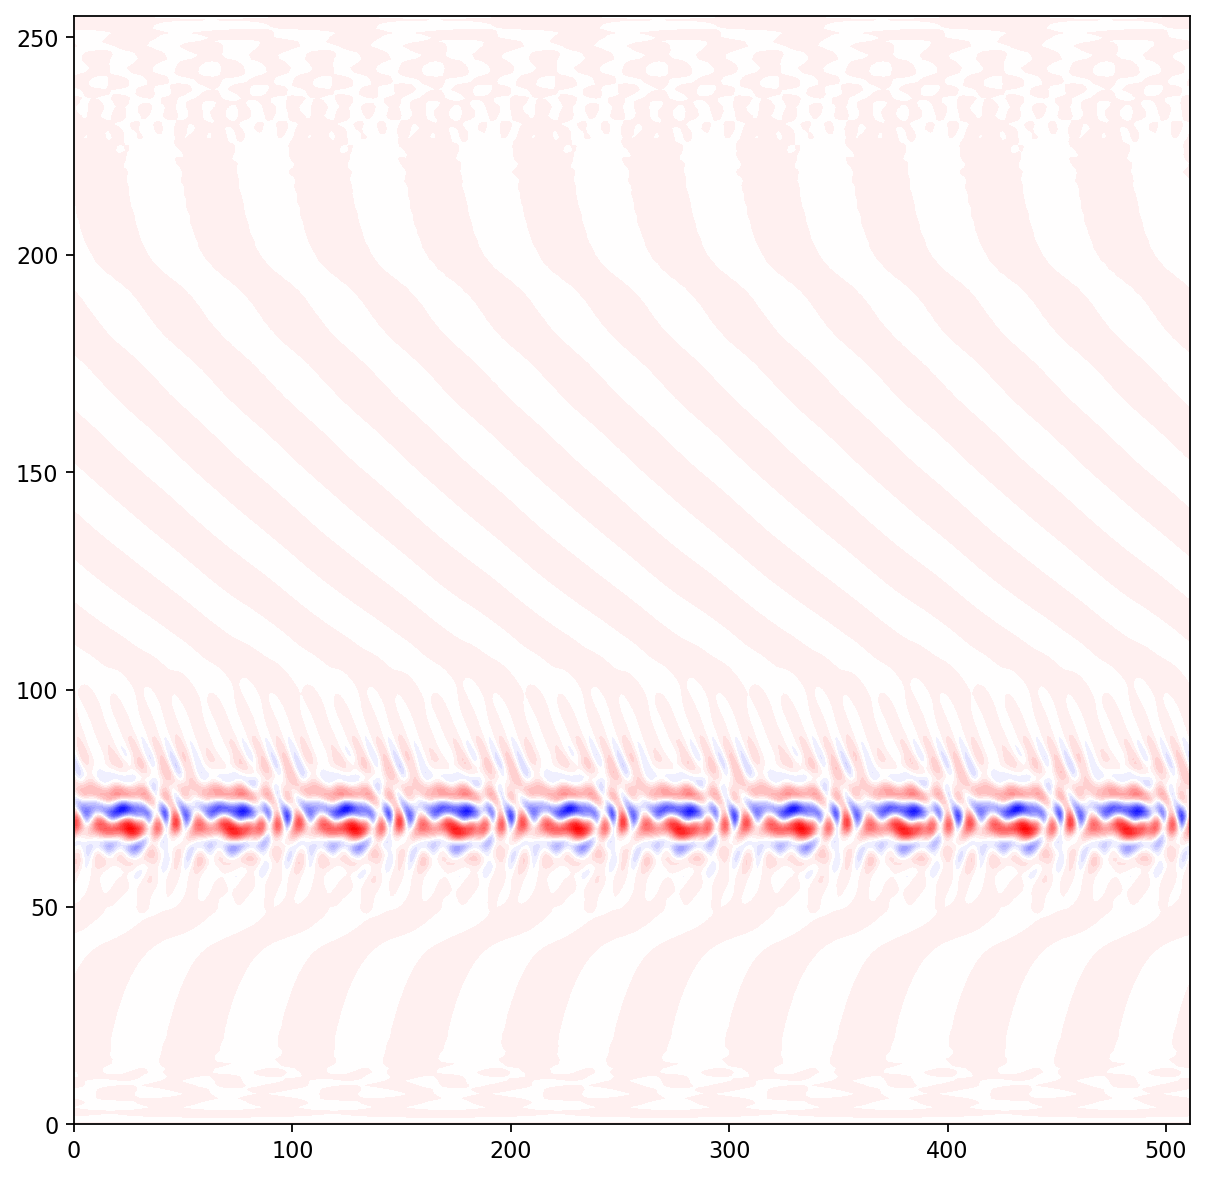

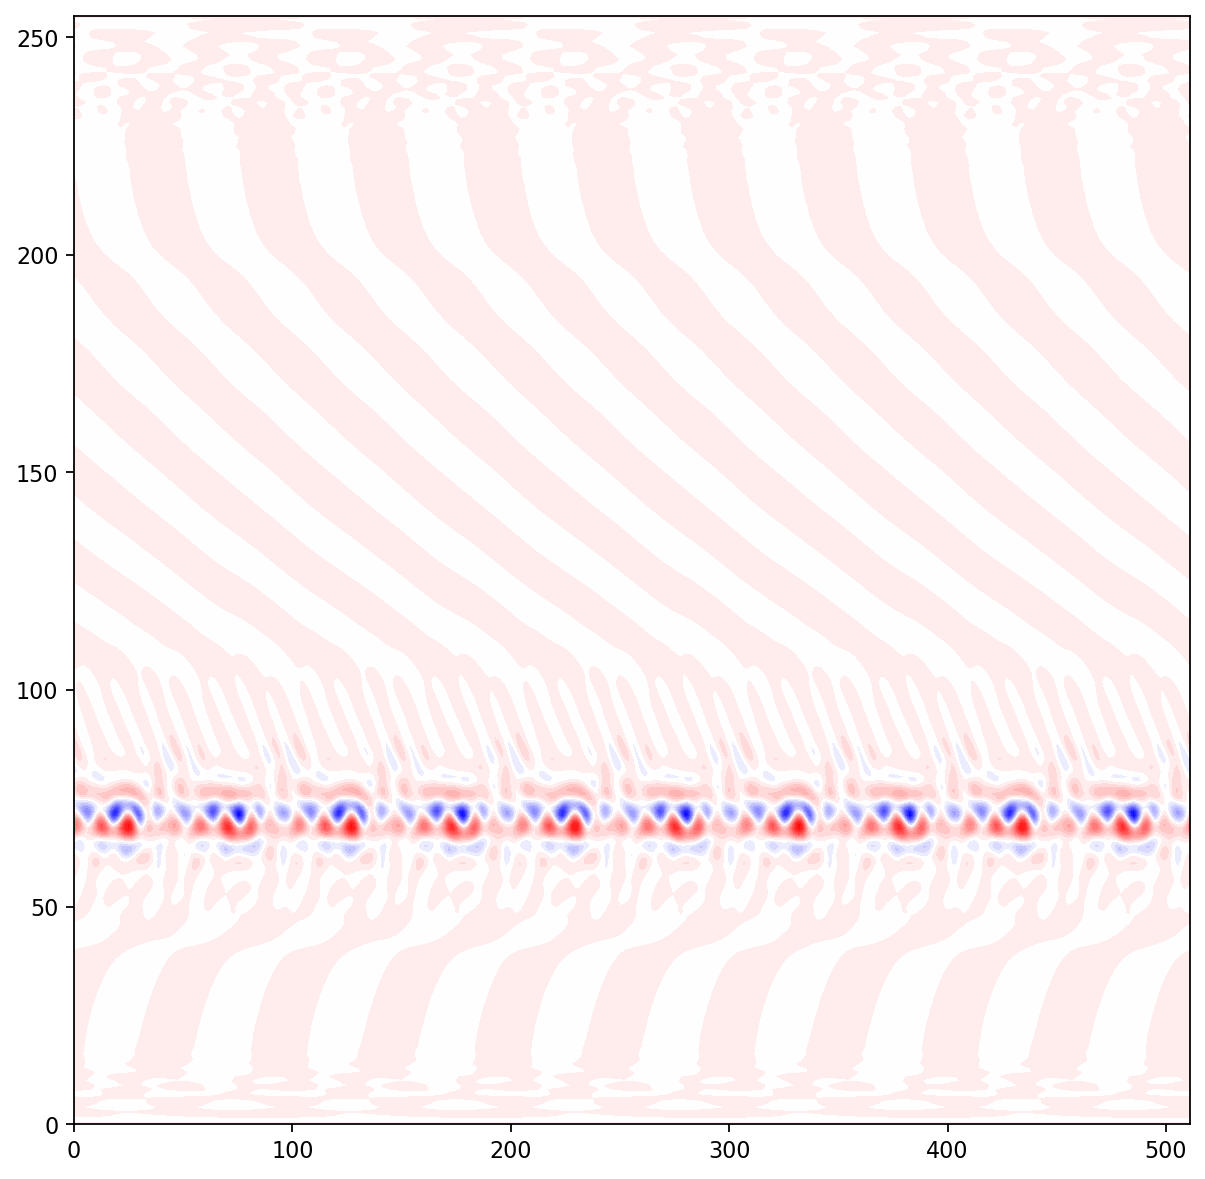

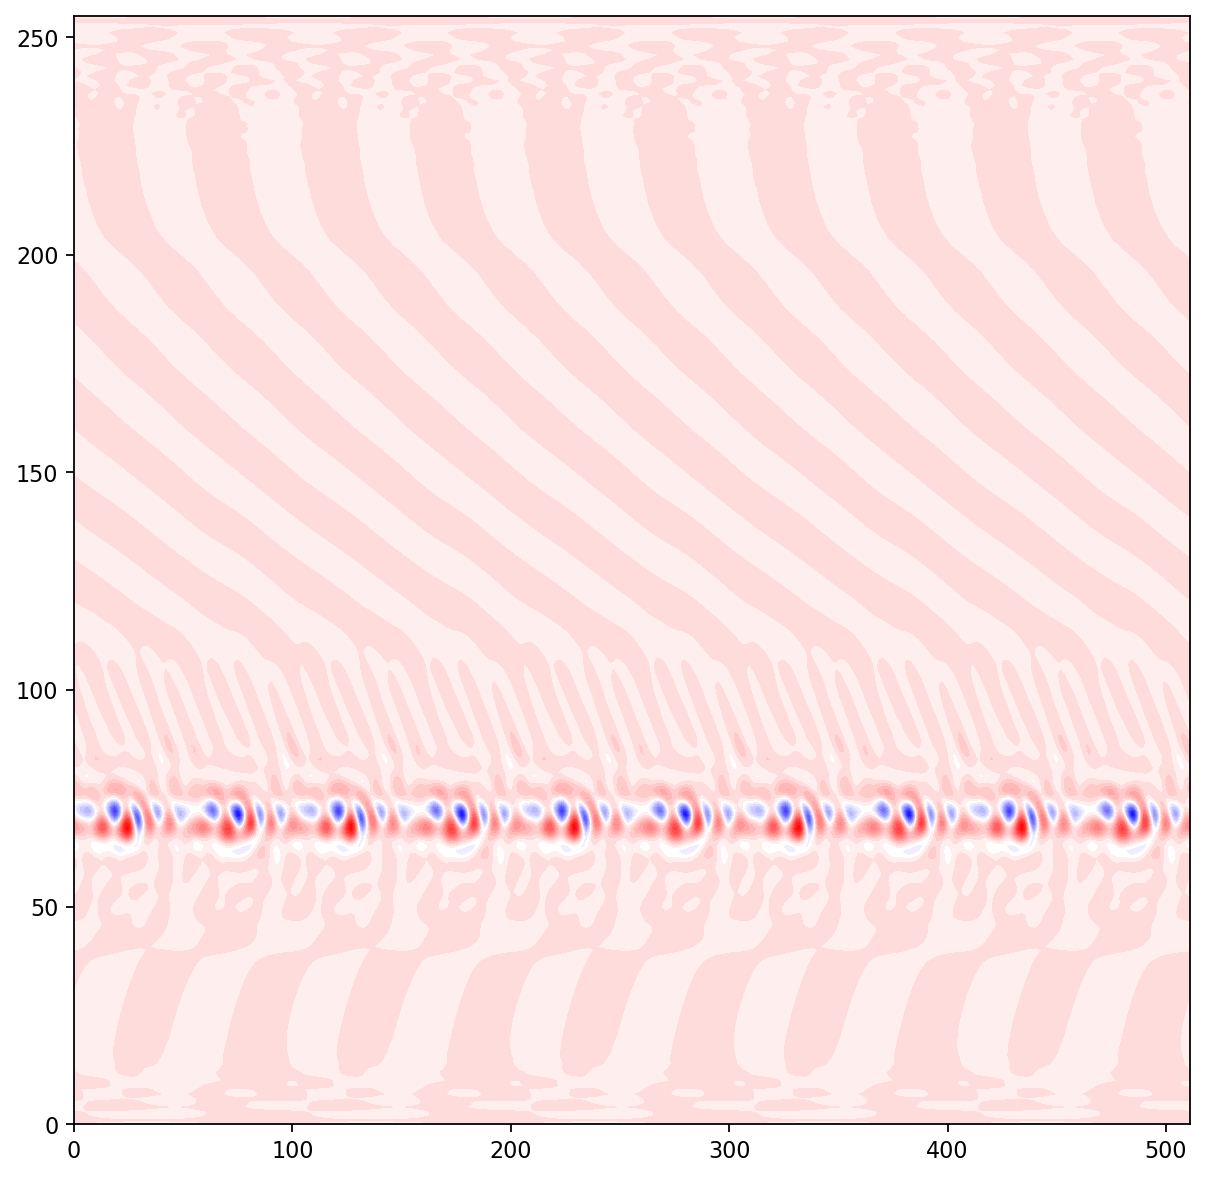

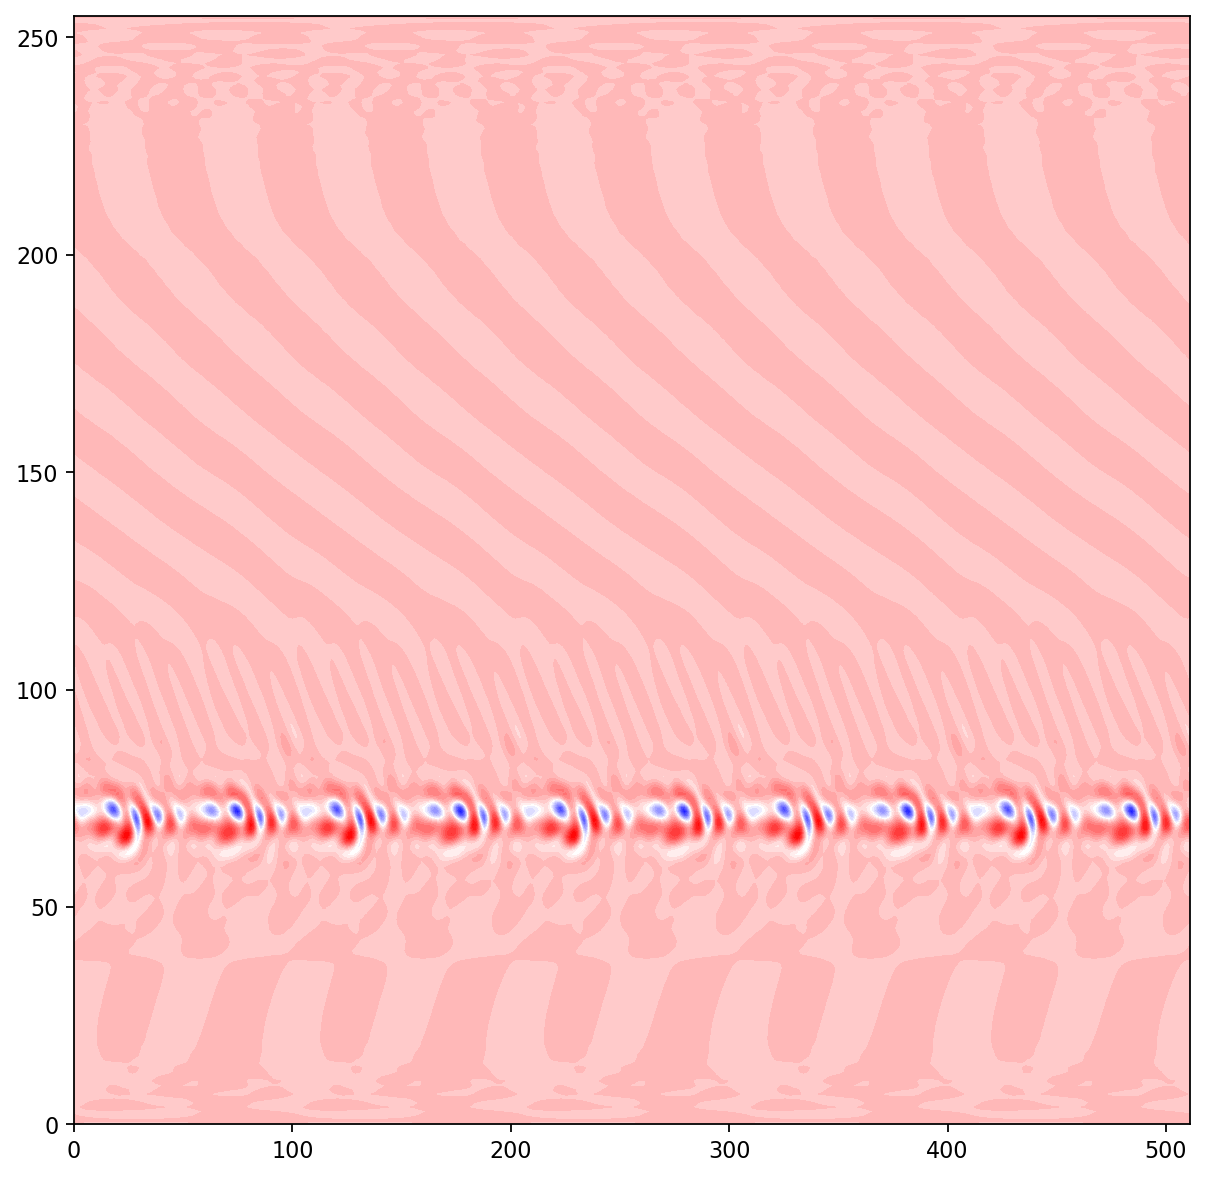

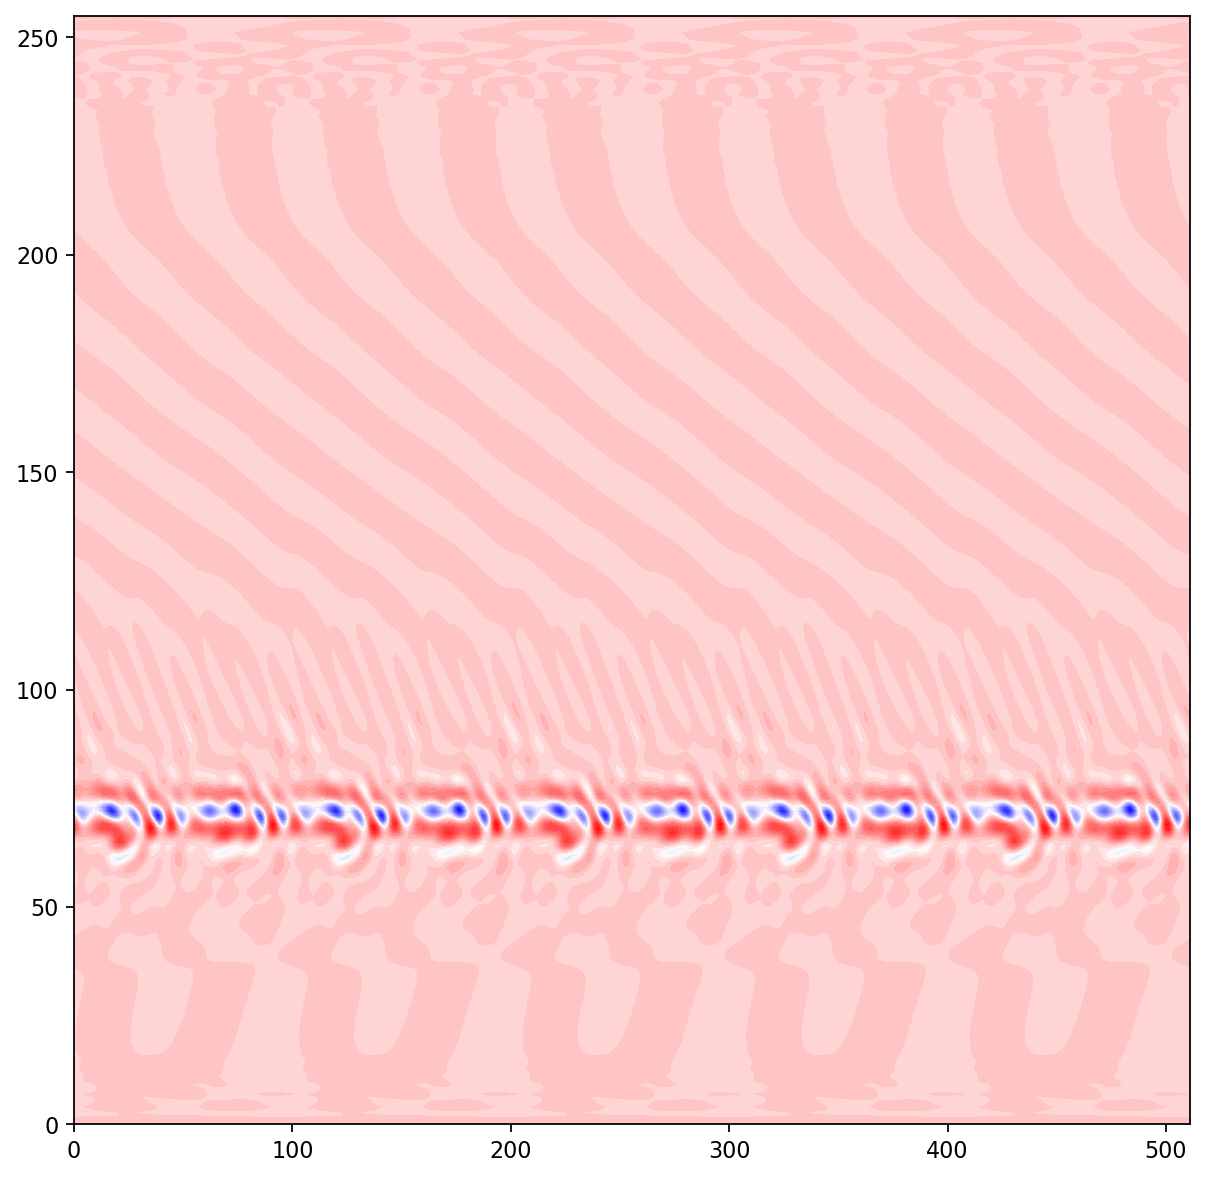

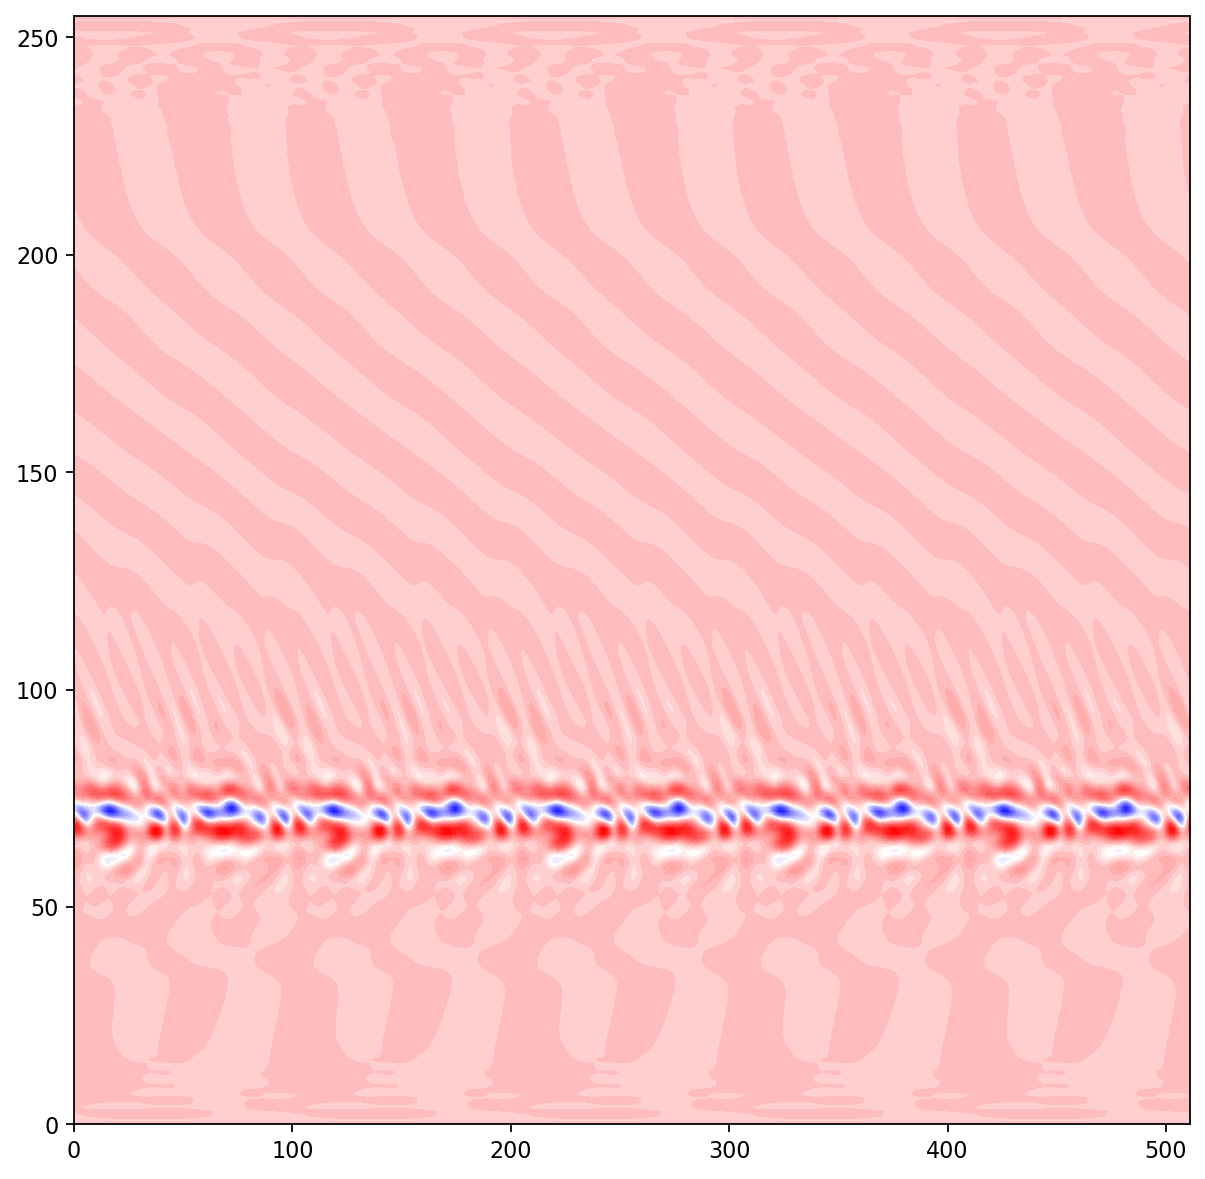

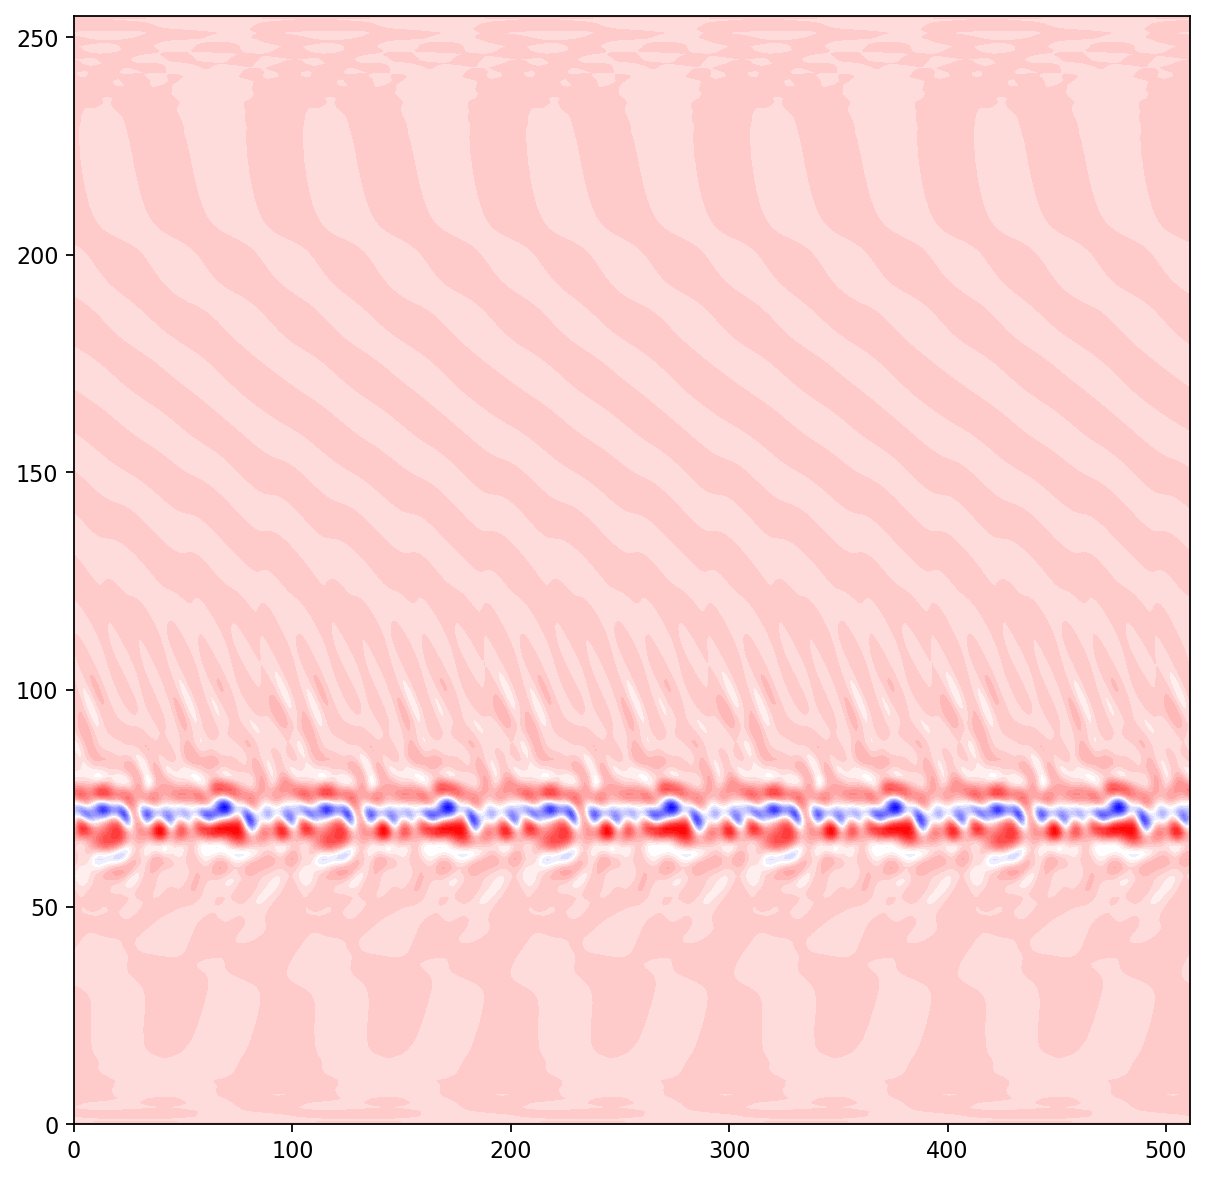

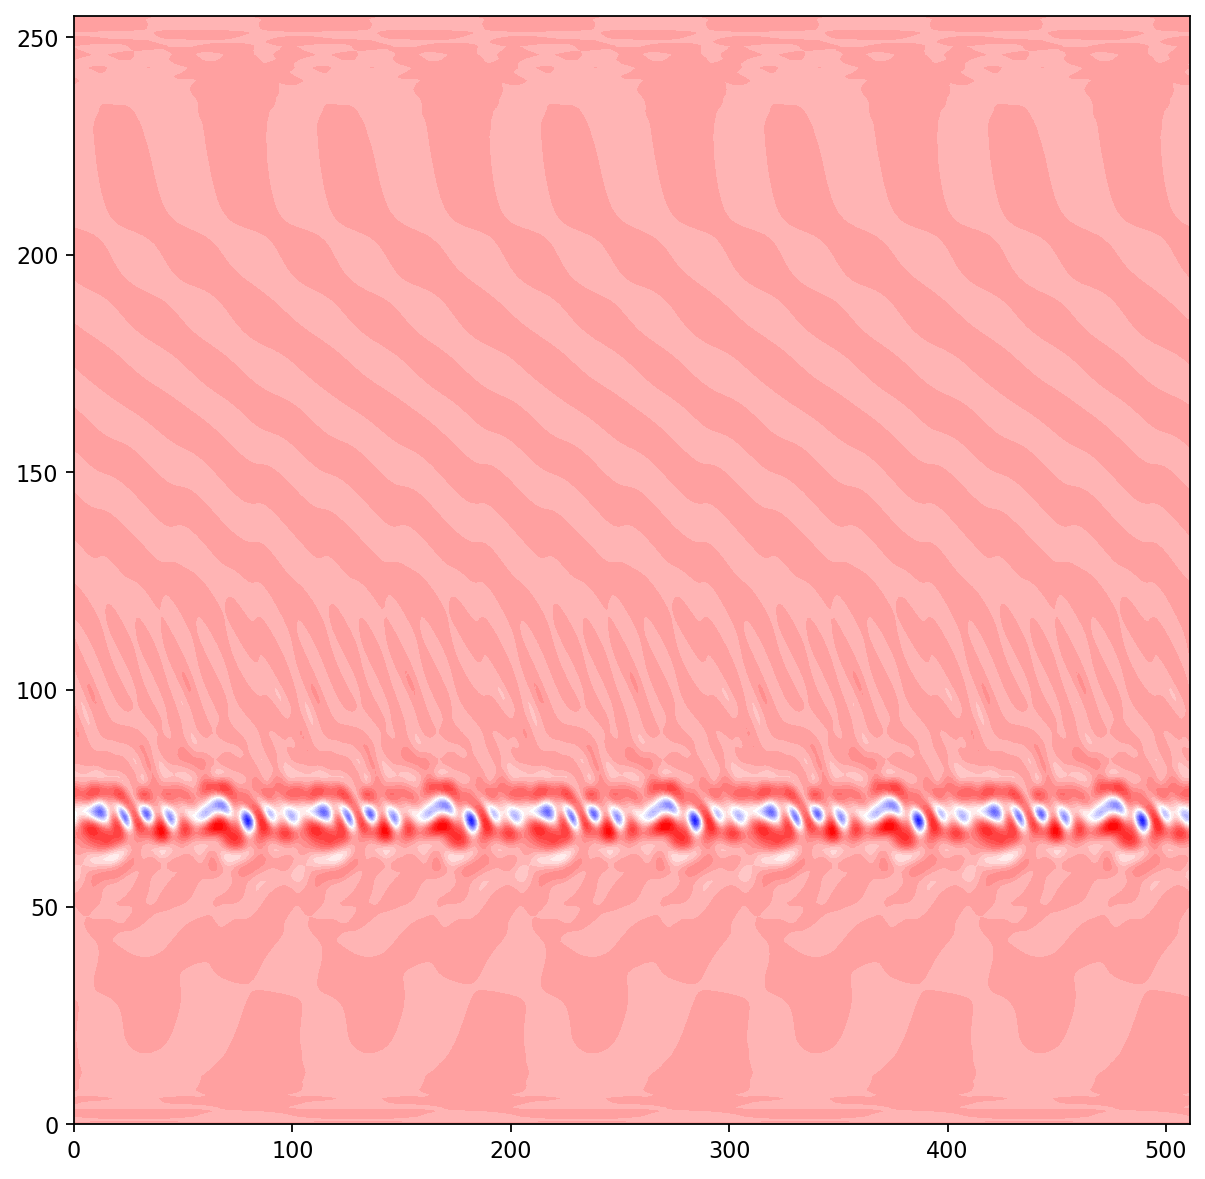

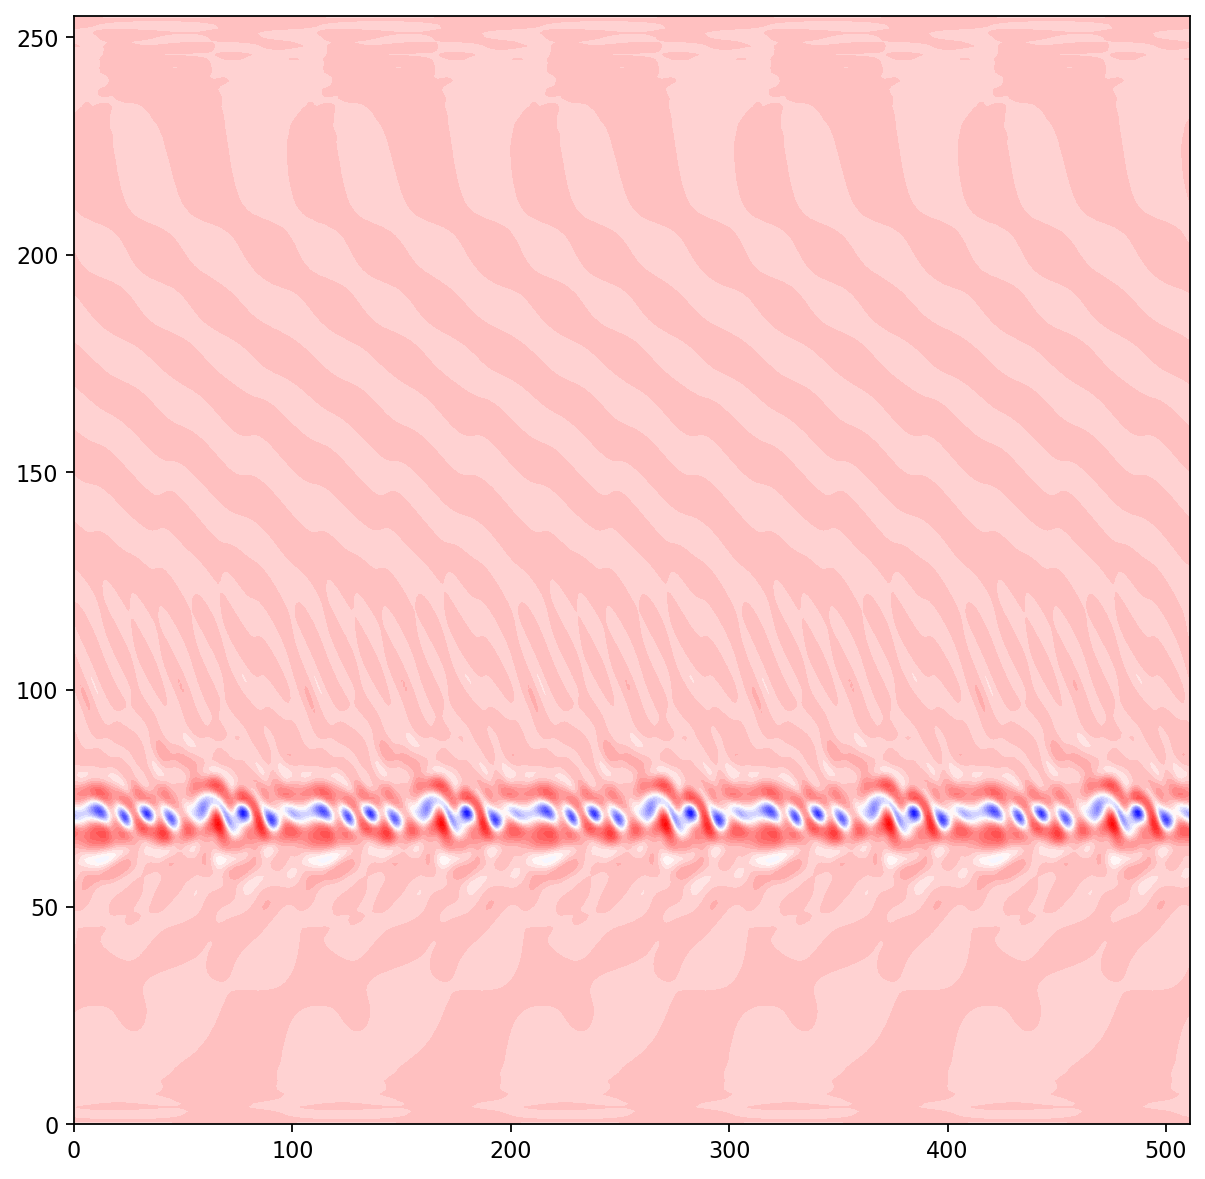

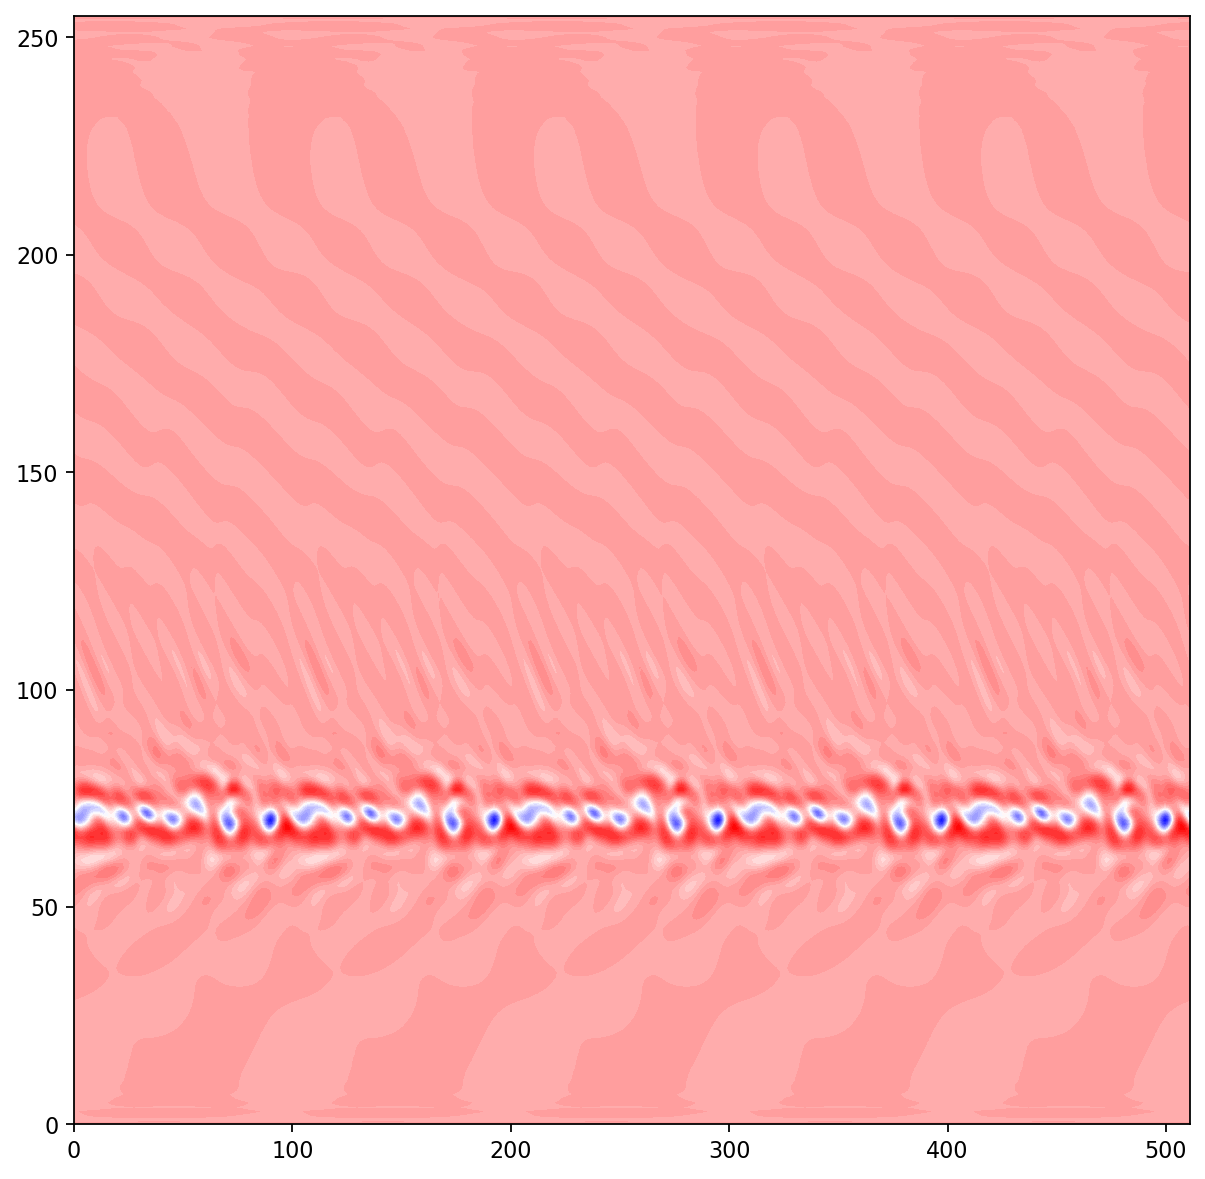

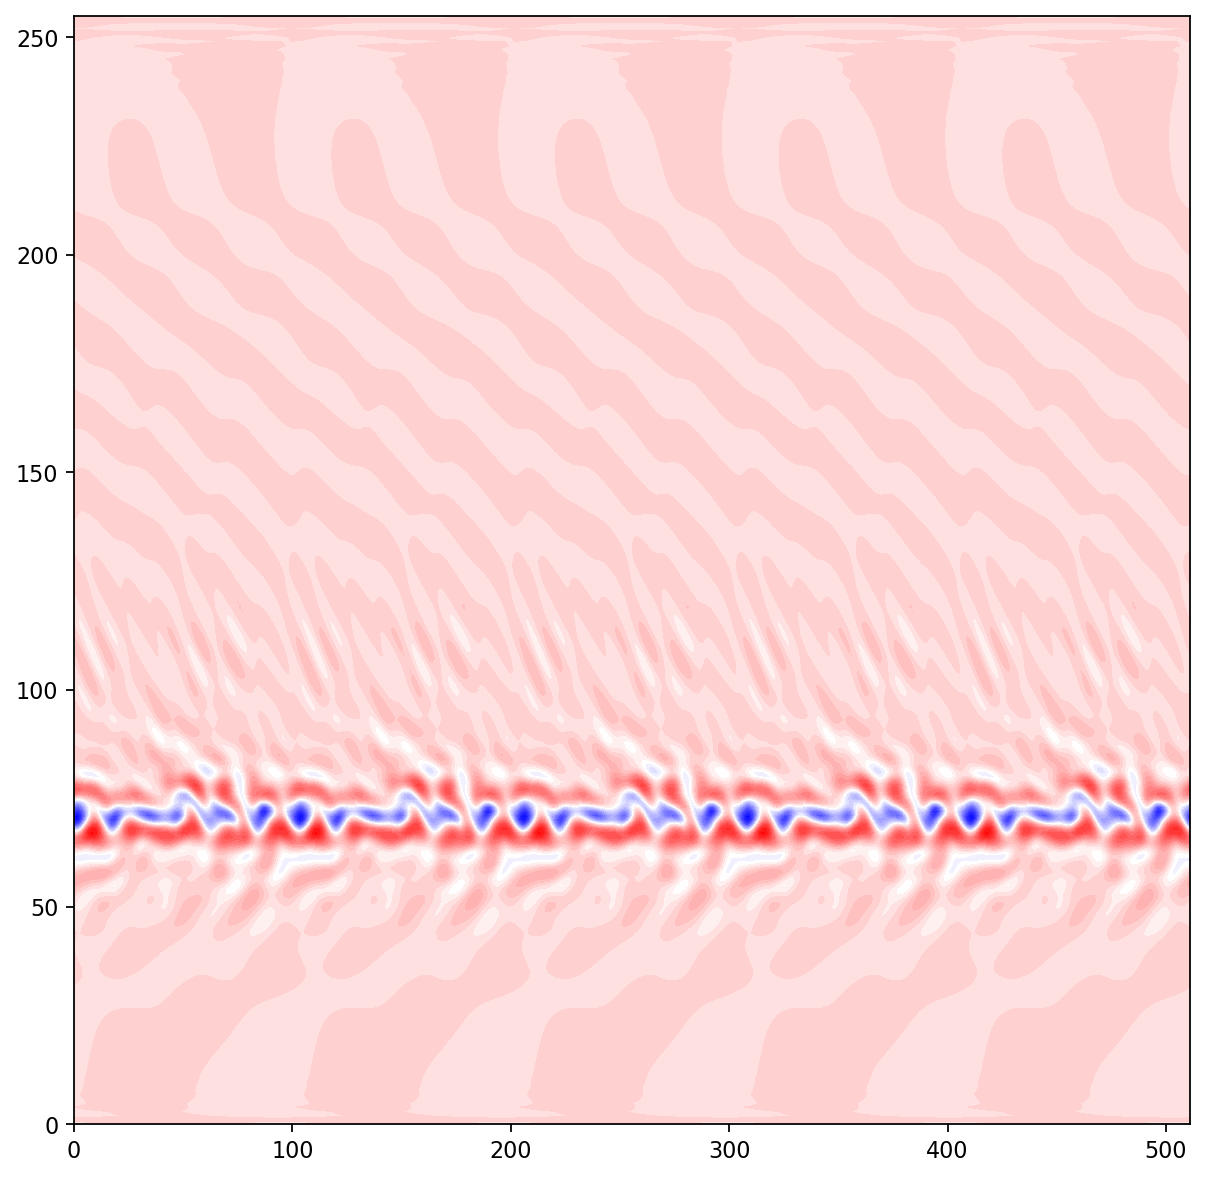

In [300]:
for i in range(19):
    ig, ax = plt.subplots(figsize = (9,9), dpi = 160)
    vor_sp = np.abs(np.fft.fftshift(np.fft.fftn(vorticity_all[i*10,])))
    ax.contourf(vorticity_all[i*10], levels = 32, cmap = "bwr")

    # ax.scatter([-beta/(2*omega)],[0], c = "k", s = 20)
    #circle1 = plt.Circle((-1.4e-11/2/7.27e-7, 0), 1.4e-11/2/7.27e-7, fill = False)
    #ax.add_patch(circle1)
    plt.show()